# Leveraging schemas for reproducible biomedical data analysis 
---
What are the key transcriptomic features that drive the transition from primary tumor to lymph node metastasis in breast cancer?

### What is a schema, and how does it ensure consistency across datasets?
---

A schema is a structured framework that defines how entities within a dataset are constrained. It help enforcing a rules on what values are allowed and what are not. Which in turn enforces consistency and helps validation.

We will explore:

- What are features and labels? Why are they crucial for structuring biological data?
- How can we create and register features and labels in LaminDB?
- What is a schema, and how does it ensure consistency across datasets?
- How can we make datasets adhere to a schema?
- How does proper structuring make datasets more findable and interoperable?
- How does it help maintain a clean and manageable analysis workflow?

By the end of this tutorial, you will understand how to structure and curate your biological datasets using LaminDB, enabling you to seamlessly integrate multiple experiments, make your datasets more discoverable, and keep your data analysis pipeline efficient and reproducible

In [ ]:
import lamindb as ln
import bionty as bt

In [46]:
import scvi 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
ln.track()

→ loaded Transform('d8go2xl9RztW0000'), re-started Run('ecNrPXyD...') at 2025-02-26 01:41:20 UTC
→ notebook imports: anndata==0.11.3 bionty==1.1.0 lamindb==1.1a1 pandas==2.2.3 scanpy==1.11.0


In [12]:
import pandas as pd
import scanpy as sc
import anndata
import scipy.sparse as sp

In [14]:
data_dir = "/Users/paulinampaiz/Desktop/myLamin/data/"

sample_info = {
    data_dir + "GSM5457199_A2019-1.expression_matrix.txt.gz": ("P1", "primary"),
    data_dir + "GSM5457200_A2019-2.expression_matrix.txt.gz": ("P1", "LN1"),
    data_dir + "GSM5457201_A2019-3.expression_matrix.txt.gz": ("P1", "LN2"),
    data_dir + "GSM5457202_B2019-1.expression_matrix.txt.gz": ("P2", "primary"),
    data_dir + "GSM5457203_B2019-2.expression_matrix.txt.gz": ("P2", "LN1"),
    data_dir + "GSM5457204_B2019-3.expression_matrix.txt.gz": ("P2", "LN2"),
    data_dir + "GSM5457205_C2020-1.expression_matrix.txt.gz": ("P3", "primary"),
    data_dir + "GSM5457206_C2020-2.expression_matrix.txt.gz": ("P3", "LN1"),
    data_dir + "GSM5457207_C2020-3.expression_matrix.txt.gz": ("P3", "LN2"),
    data_dir + "GSM5457208_D2020-1.expression_matrix.txt.gz": ("P4", "primary"),
    data_dir + "GSM5457209_D2020-2.expression_matrix.txt.gz": ("P4", "LN1"),
    data_dir + "GSM5457210_D2020-3.expression_matrix.txt.gz": ("P4", "LN2"),
    data_dir + "GSM5457211_E2020-1.expression_matrix.txt.gz": ("P5", "primary"),
    data_dir + "GSM5457212_E2020-2.expression_matrix.txt.gz": ("P5", "LN1"),
    data_dir + "GSM5457213_E2020-3.expression_matrix.txt.gz": ("P5", "LN2"),
}

In [ ]:
adatas = []

for filename, (patient_id, site) in sample_info.items():
    
    df = pd.read_csv(
        filename,
        sep="\t",
        header=0,
        index_col=0
    )
    
    ad = sc.AnnData(X=df.values.T)
    ad.var_names = df.index        # gene names
    ad.obs_names = df.columns      # cell IDs

    if not sp.issparse(ad.X):
        ad.X = sp.csr_matrix(ad.X)
    
    # Annotate with patient and site 
    ad.obs["patient"] = patient_id
    ad.obs["site"] = site
    
    print("Num cells in this file:", ad.n_obs)
    print("Unique site in this AnnData:", ad.obs["site"].unique())
    
    adatas.append(ad)


Loading file: /Users/paulinampaiz/Desktop/myLamin/data/GSM5457199_A2019-1.expression_matrix.txt.gz
Assigned patient_id = P1 site = primary
Num cells in this file: 3267
Unique site in this AnnData: ['primary']
Loading file: /Users/paulinampaiz/Desktop/myLamin/data/GSM5457200_A2019-2.expression_matrix.txt.gz
Assigned patient_id = P1 site = LN1
Num cells in this file: 8607
Unique site in this AnnData: ['LN1']
Loading file: /Users/paulinampaiz/Desktop/myLamin/data/GSM5457201_A2019-3.expression_matrix.txt.gz
Assigned patient_id = P1 site = LN2
Num cells in this file: 16661
Unique site in this AnnData: ['LN2']
Loading file: /Users/paulinampaiz/Desktop/myLamin/data/GSM5457202_B2019-1.expression_matrix.txt.gz
Assigned patient_id = P2 site = primary
Num cells in this file: 11467
Unique site in this AnnData: ['primary']
Loading file: /Users/paulinampaiz/Desktop/myLamin/data/GSM5457203_B2019-2.expression_matrix.txt.gz
Assigned patient_id = P2 site = LN1
Num cells in this file: 11356
Unique site i

In [ ]:
adata_merged_inner = sc.concat(adatas, axis=0, join="inner", index_unique="-")
print("Merged AnnData shape (inner join):", adata_merged_inner.shape)
print("Unique patients:", adata_merged_inner.obs["patient"].unique())
print("Unique sites:", adata_merged_inner.obs["site"].unique())

In [ ]:
adata_merged = anndata.read("adata_merged.h5ad")

/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
adata_merged.layers["counts"] = adata_merged.X.copy()

In [ ]:
# QC
sc.pp.calculate_qc_metrics(adata_merged, inplace=True)
sc.pp.filter_cells(adata_merged, min_genes=200)
sc.pp.filter_genes(adata_merged, min_cells=3)

In [36]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

In [ ]:
# Highly Variable Genes
sc.pp.highly_variable_genes(adata_merged, n_top_genes=2000, subset=True)
print(adata_merged.shape)

Shape after HVG selection: (108038, 2000)


In [38]:
sc.pp.scale(adata_merged, max_value=10)

In [ ]:
scvi.model.SCVI.setup_anndata(adata_merged, batch_key="patient", layer="counts")


In [ ]:
model = scvi.model.SCVI(adata_merged)
model.train(max_epochs=20)  

/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Epoch 20/20: 100%|██████████| 20/20 [03:20<00:00,  9.72s/it, v_num=1, train_loss_step=148, train_loss_epoch=161]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:20<00:00, 10.04s/it, v_num=1, train_loss_step=148, train_loss_epoch=161]


In [ ]:
latent = model.get_latent_representation()
adata_merged.obsm["X_scVI"] = latent
print("Latent representation shape:", latent.shape)

Latent representation shape: (108038, 10)


In [ ]:
X_latent = adata_merged.obsm["X_scVI"]
binary_labels = np.where(adata_merged.obs["site"].values == "primary", 0, 1)

emb_tensor = torch.tensor(X_latent, dtype=torch.float)
labels_tensor = torch.tensor(binary_labels, dtype=torch.long)

In [ ]:
class LatentDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return self.embeddings.shape[0]
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

dataset = LatentDataset(emb_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
        
    def forward(self, x):
        return self.net(x)

# Instantiate the projection head: input dim=10, hidden=32, output dim=32
proj_head = ProjectionHead(in_channels=10, hidden_channels=32, out_channels=32)

In [ ]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        # features: [batch_size, projection_dim]
        features = F.normalize(features, p=2, dim=1)
        batch_size = features.shape[0]

        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        # mask for positive pairs: same label and not self-comparison
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float()
        mask = mask - torch.eye(batch_size, device=mask.device)

        exp_sim = torch.exp(similarity_matrix)

        # sum over all pairs except self
        diag_exp = torch.exp(torch.diag(similarity_matrix)).view(-1, 1)
        denom = exp_sim.sum(dim=1, keepdim=True) - diag_exp

        # sum over positive pairs
        numerator = (exp_sim * mask).sum(dim=1, keepdim=True)

        loss = -torch.log((numerator / (denom + 1e-8)) + 1e-8)
        loss = loss.mean()
        return loss

contrastive_loss = SupConLoss(temperature=0.07)

In [ ]:
# Train projection head 
optimizer = optim.Adam(proj_head.parameters(), lr=1e-3)

num_epochs = 50  
proj_head.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_emb, batch_labels in dataloader:
        optimizer.zero_grad()
        projections = proj_head(batch_emb) 
        loss = contrastive_loss(projections, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

Epoch 1/50, Loss: 0.1424
Epoch 2/50, Loss: 0.1357
Epoch 3/50, Loss: 0.1254
Epoch 4/50, Loss: 0.1308
Epoch 5/50, Loss: 0.1225
Epoch 6/50, Loss: 0.1308
Epoch 7/50, Loss: 0.1213
Epoch 8/50, Loss: 0.1283
Epoch 9/50, Loss: 0.1296
Epoch 10/50, Loss: 0.1201
Epoch 11/50, Loss: 0.1198
Epoch 12/50, Loss: 0.1191
Epoch 13/50, Loss: 0.1188
Epoch 14/50, Loss: 0.1262
Epoch 15/50, Loss: 0.1190
Epoch 16/50, Loss: 0.1267
Epoch 17/50, Loss: 0.1216
Epoch 18/50, Loss: 0.1206
Epoch 19/50, Loss: 0.1217
Epoch 20/50, Loss: 0.1197
Epoch 21/50, Loss: 0.1257
Epoch 22/50, Loss: 0.1171
Epoch 23/50, Loss: 0.1266
Epoch 24/50, Loss: 0.1176
Epoch 25/50, Loss: 0.1164
Epoch 26/50, Loss: 0.1239
Epoch 27/50, Loss: 0.1171
Epoch 28/50, Loss: 0.1184
Epoch 29/50, Loss: 0.1182
Epoch 30/50, Loss: 0.1187
Epoch 31/50, Loss: 0.1236
Epoch 32/50, Loss: 0.1158
Epoch 33/50, Loss: 0.1198
Epoch 34/50, Loss: 0.1243
Epoch 35/50, Loss: 0.1216
Epoch 36/50, Loss: 0.1244
Epoch 37/50, Loss: 0.1247
Epoch 38/50, Loss: 0.1230
Epoch 39/50, Loss: 0.

In [ ]:
# New embeddings
proj_head.eval()
with torch.no_grad():
    new_embeddings = proj_head(emb_tensor).cpu().numpy()
print("New embedding shape:", new_embeddings.shape)

adata_merged.obsm["X_contrastive"] = new_embeddings

New embedding shape: (108038, 32)


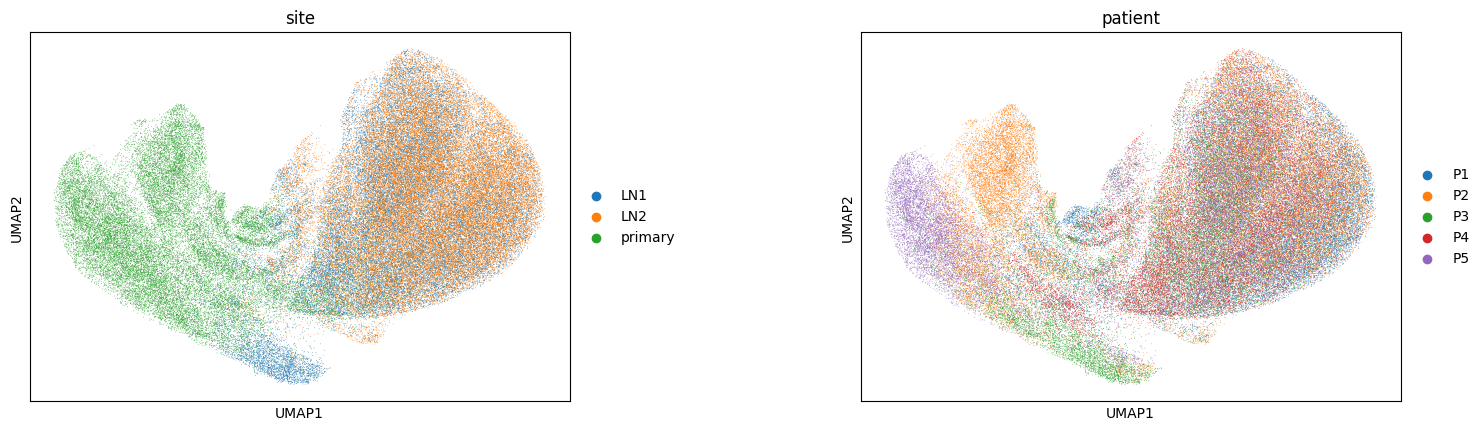

In [54]:
sc.pp.neighbors(adata_merged, use_rep="X_contrastive", n_neighbors=15)
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=["site", "patient"], wspace=0.4)